# Import needed modules

In [2]:
!pip install tensorflow==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 93.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 113.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 69.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: tensorf

In [3]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Data Preprocessing

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
! unzip '/content/drive/MyDrive/chest_xray.zip'

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0641-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0642-0001 - Copy.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0642-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0643-0001 - Copy.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0643-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0645-0001 - Copy.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0647-0001 - Copy.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0647-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0648-0001 - Copy.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0648-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0649-0001 - Copy.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0649-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL2-IM-0650-0001 - Co

**Read data and store it in dataframe**

In [6]:
# Generate data paths with labels
data_dir = '/content/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [7]:
df

,filepaths,labels
0,/content/chest_xray/train/PNEUMONIA/person38_b...,PNEUMONIA
1,/content/chest_xray/train/PNEUMONIA/person288_...,PNEUMONIA
2,/content/chest_xray/train/PNEUMONIA/person1425...,PNEUMONIA
3,/content/chest_xray/train/PNEUMONIA/person1901...,PNEUMONIA
4,/content/chest_xray/train/PNEUMONIA/person810_...,PNEUMONIA
...,...,...
6003,/content/chest_xray/train/NORMAL/NORMAL2-IM-10...,NORMAL
6004,/content/chest_xray/train/NORMAL/NORMAL2-IM-06...,NORMAL
6005,/content/chest_xray/train/NORMAL/IM-0450-0001 ...,NORMAL
6006,/content/chest_xray/train/NORMAL/NORMAL2-IM-12...,NORMAL


**Split dataframe into train, valid, and test**

In [8]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

**Create image data generator**

In [9]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 4806 validated image filenames belonging to 2 classes.
Found 721 validated image filenames belonging to 2 classes.
Found 481 validated image filenames belonging to 2 classes.


**Show sample from train data**

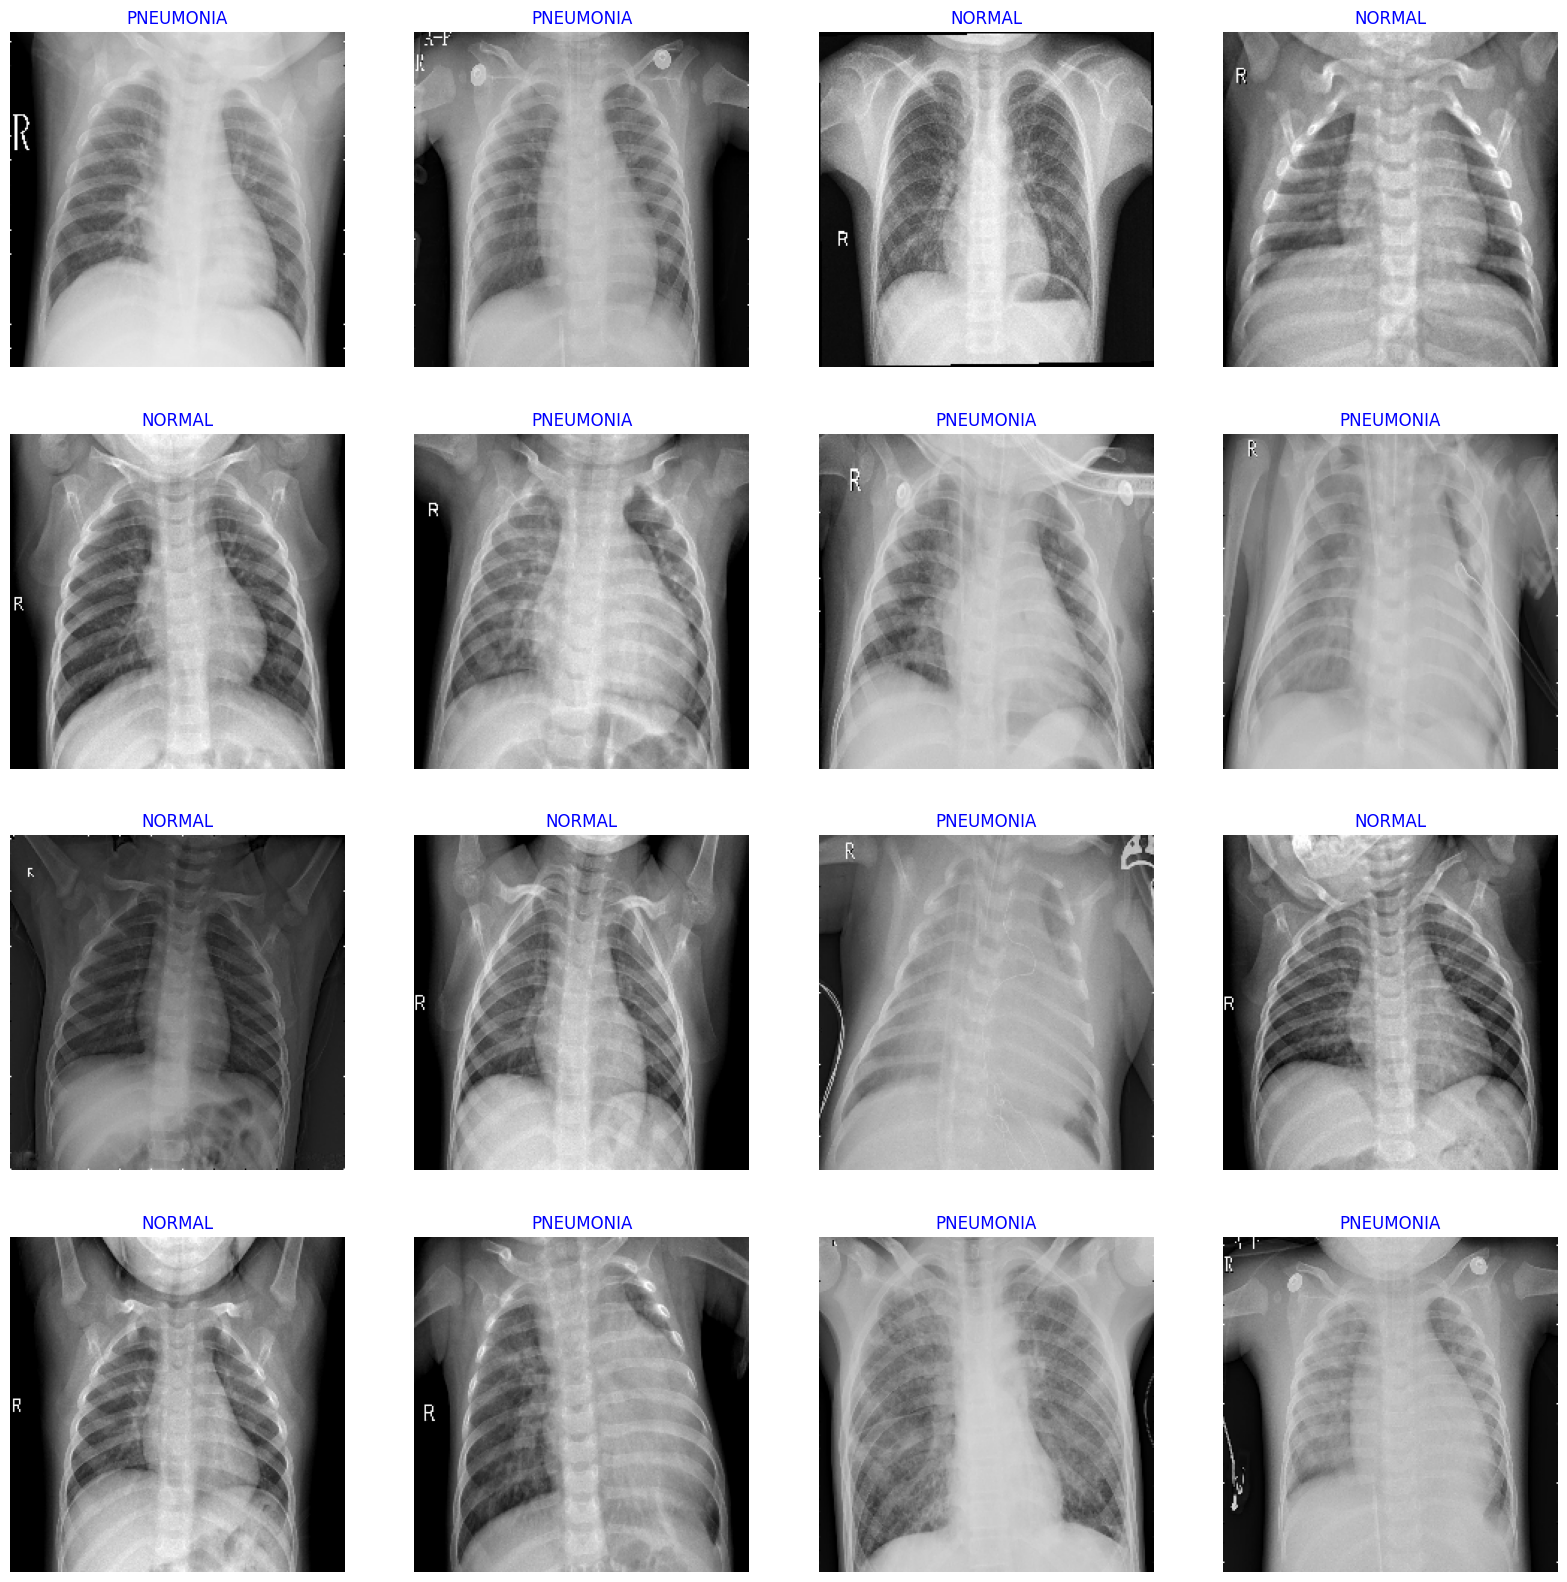

In [10]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')

# Model Structure

**Generic Model Creation**

In [11]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 4,383,141
Trainable params: 4,338,558
Non-t

**Train model**

In [12]:
batch_size = 16   # set batch size for training
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/10
301/301 [==============================] - 105s 286ms/step - loss: 4.6772 - accuracy: 0.9384 - val_loss: 3.0568 - val_accuracy: 0.8988
Epoch 2/10
301/301 [==============================] - 79s 262ms/step - loss: 2.2320 - accuracy: 0.9769 - val_loss: 1.6094 - val_accuracy: 0.9903
Epoch 3/10
301/301 [==============================] - 85s 281ms/step - loss: 1.2317 - accuracy: 0.9906 - val_loss: 0.8932 - val_accuracy: 0.9958
Epoch 4/10
301/301 [==============================] - 76s 252ms/step - loss: 0.6983 - accuracy: 0.9906 - val_loss: 0.5067 - val_accuracy: 0.9986
Epoch 5/10
301/301 [==============================] - 80s 265ms/step - loss: 0.4119 - accuracy: 0.9950 - val_loss: 0.3055 - val_accuracy: 0.9972
Epoch 6/10
301/301 [==============================] - 78s 259ms/step - loss: 0.2648 - accuracy: 0.9965 - val_loss: 0.2001 - val_accuracy: 1.0000
Epoch 7/10
301/301 [==============================] - 76s 251ms/step - loss: 0.1897 - accuracy: 0.9954 - val_loss: 0.1522 - val_a

**Display model performance**

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

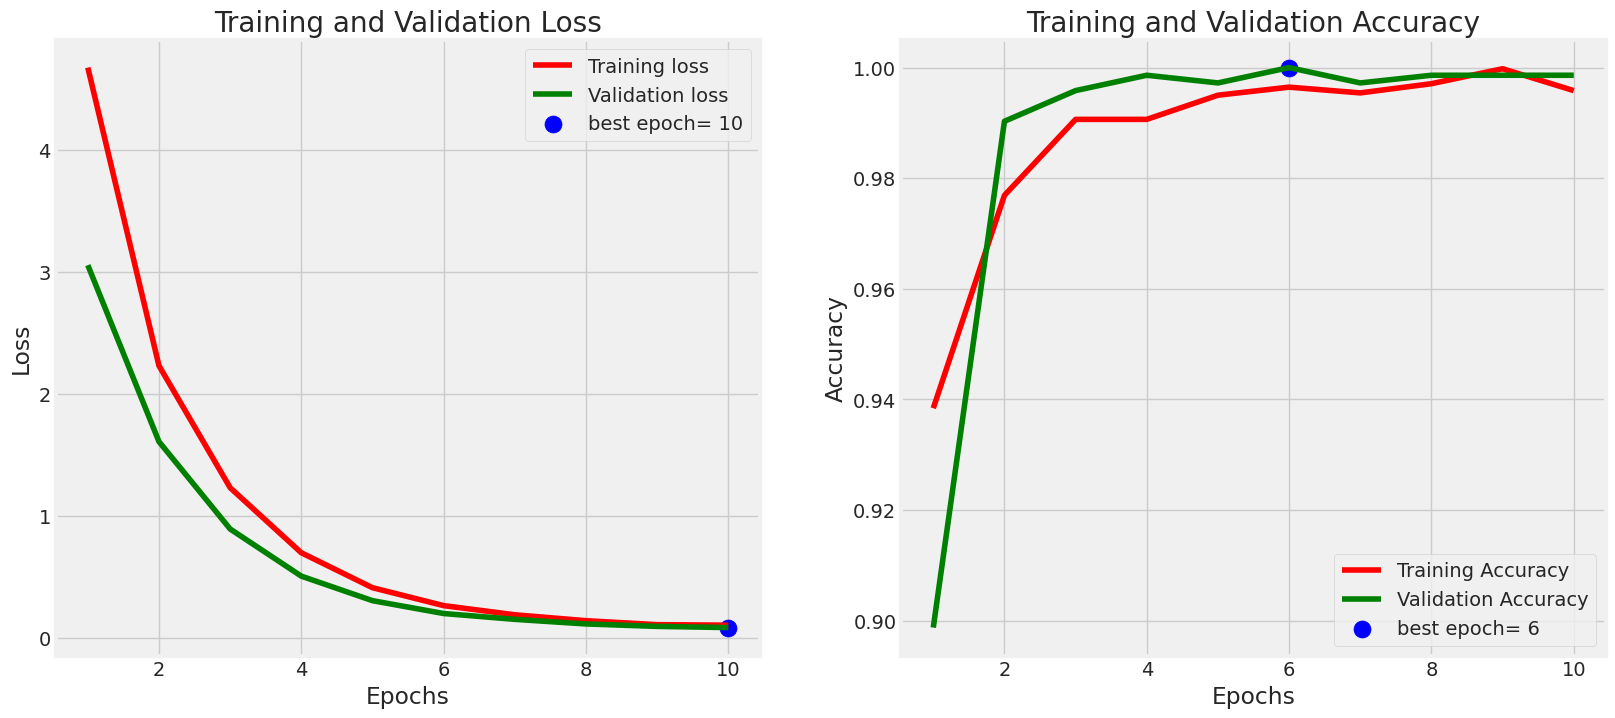

In [13]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout

**Evaluate model**

In [14]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

13/13 [==============================] - 6s 356ms/step - loss: 0.0835 - accuracy: 1.0000
Train Loss:  0.08099856972694397
Train Accuracy:  1.0
--------------------
Validation Loss:  0.08137667924165726
Validation Accuracy:  1.0
--------------------
Test Loss:  0.08353154361248016
Test Accuracy:  1.0


**Get Predictions**

In [15]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

**Confusion Matrics and Classification Report**

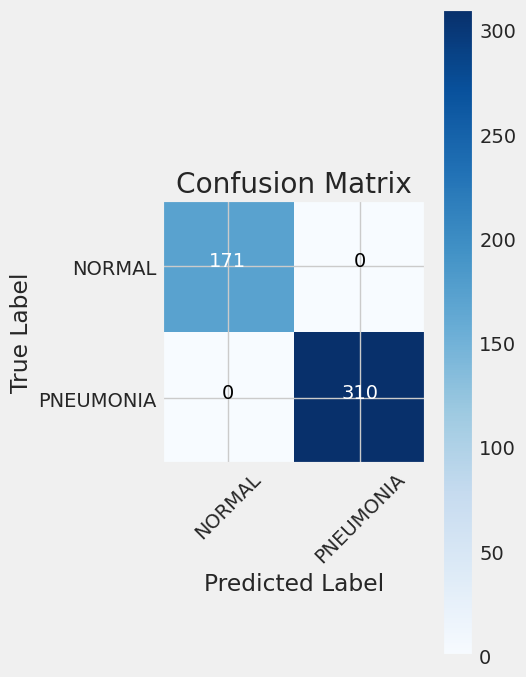

In [51]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (5, 7))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [17]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00       171
   PNEUMONIA       1.00      1.00      1.00       310

    accuracy                           1.00       481
   macro avg       1.00      1.00      1.00       481
weighted avg       1.00      1.00      1.00       481



**Save model**

In [18]:
#Save the model
import tensorflow as tf
tf.keras.models.save_model(model,'Pneumonia Detection .h5')

**Prediction using loaded_model**

In [40]:
loaded_model = tf.keras.models.load_model('/content/Pneumonia Detection .h5', compile=False)
loaded_model.compile(Adam(learning_rate= 0.001), loss= 'binary_crossentropy', metrics= ['accuracy'])

In [50]:
image_path = '/content/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((250, 250))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = model.predict(img_array)
class_labels = ['Normal', 'Pneumonia']
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")
print(tf.argmax(score))

1/1 [==============================] - 0s 95ms/step
Pneumonia
tf.Tensor(1, shape=(), dtype=int64)
